In [1]:
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import ImageFile
from tensorflow.keras.utils import Sequence
import numpy as np
from keras.callbacks import Callback
import sys

In [3]:
# Set to load truncated images, if any
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialize your data generators with improved settings
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

class BalancedDataGenerator(Sequence):
    def __init__(self, directory, image_data_generator, target_size=(224, 224), batch_size=32, shuffle=True, seed=None):
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.generator = image_data_generator.flow_from_directory(
            directory,
            target_size=target_size,
            class_mode='categorical',
            batch_size=batch_size,  # Update to actual batch size for more effective learning
            shuffle=shuffle,
            seed=seed)
        self.num_classes = len(self.generator.class_indices)
    
    def __len__(self):
        return int(np.ceil(len(self.generator.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x, batch_y = self.generator.next()
        return batch_x, batch_y

# Load DenseNet121 pre-trained on ImageNet without the top layer
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(15, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Path updates for generators
train_path = '/path_to_train_directory'  # Update this path
val_path = '/path_to_validation_directory'  # Update this path
test_path = '/path_to_test_directory'  # Update this path

# Create instances of BalancedDataGenerator
train_generator = BalancedDataGenerator(train_path, train_datagen, batch_size=32)
validation_generator = BalancedDataGenerator(val_path, test_val_datagen, batch_size=32)
test_generator = test_val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

FileNotFoundError: [Errno 2] No such file or directory: '/path_to_train_directory'

In [4]:
# Create instances of BalancedDataGenerator
train_generator = BalancedDataGenerator(
    'balanced_images_15_cat/train',
    train_datagen,
    batch_size=32
)

validation_generator = BalancedDataGenerator(
    'balanced_images_15_cat/val',
    test_val_datagen,
    batch_size=32
)

# Standard generator for testing (balance not typically required)
test_generator = test_val_datagen.flow_from_directory(
    'balanced_images_15_cat/test',
    target_size=(224, 224),
    batch_size=12,
    class_mode='categorical',
    shuffle=False
)

Found 141467 images belonging to 15 classes.
Found 91344 images belonging to 15 classes.
Found 78812 images belonging to 15 classes.


In [5]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Adjust based on the size of your dataset
    epochs=10,  # Adjust based on your early experiments
    validation_data=validation_generator,
    validation_steps=10  # Adjust based on the size of your validation set
)

Epoch 1/10
10/10 [==============================] - 93s 9s/step - loss: 2.4914 - accuracy: 0.3938 - val_loss: 14.0401 - val_accuracy: 0.4344
Epoch 2/10
10/10 [==============================] - 86s 9s/step - loss: 2.2552 - accuracy: 0.3625 - val_loss: 24.3073 - val_accuracy: 0.1219
Epoch 3/10
10/10 [==============================] - 85s 9s/step - loss: 2.0430 - accuracy: 0.4375 - val_loss: 35.1947 - val_accuracy: 0.0812
Epoch 4/10
10/10 [==============================] - 86s 9s/step - loss: 2.0501 - accuracy: 0.4250 - val_loss: 20.3992 - val_accuracy: 0.1031
Epoch 5/10
10/10 [==============================] - 88s 9s/step - loss: 1.9512 - accuracy: 0.4656 - val_loss: 5.7743 - val_accuracy: 0.4719
Epoch 6/10
10/10 [==============================] - 89s 9s/step - loss: 1.8312 - accuracy: 0.4688 - val_loss: 12.0157 - val_accuracy: 0.4281
Epoch 7/10
10/10 [==============================] - 88s 9s/step - loss: 2.0399 - accuracy: 0.4313 - val_loss: 3.7030 - val_accuracy: 0.4375
Epoch 8/10
10/1

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)  # Adjust the steps as needed
print('Test accuracy:', test_acc)

45/50 [==========================>...] - ETA: 2s - loss: 4.5871 - accuracy: 0.0444

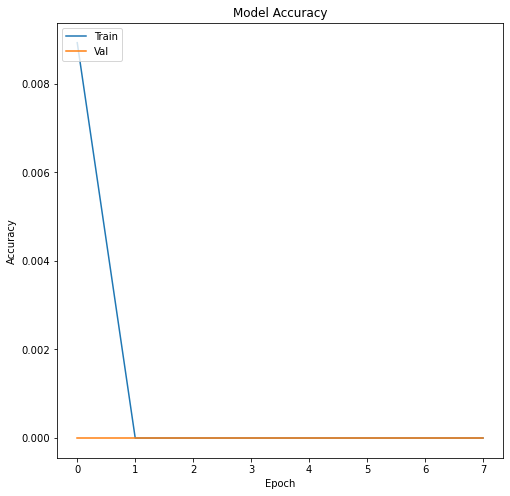

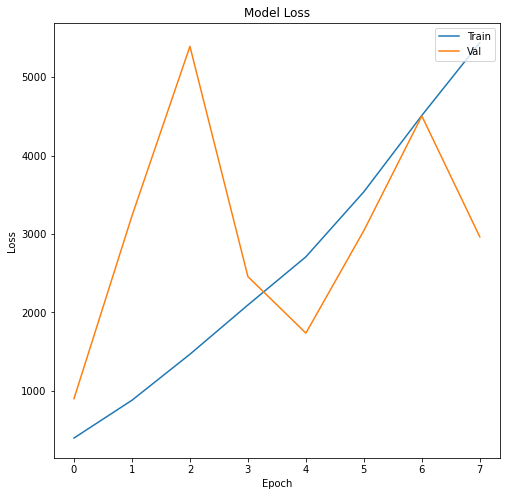

In [41]:
# Summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
